In [2]:
import pennylane as qml
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)


# The three building blocks on two qubits we will compare are:
operations = {
    ("Decomposition", "decomposition"): two_qubit_decomp,
    ("PauliRot sequence",) * 2: qml.ArbitraryUnitary,
    ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,
}

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DELL\AppData\Local\Temp\ipykernel_33812\2719096219.py:32: SyntaxWarning: invalid escape sequence '\m'
  ("$\mathrm{SU}(N)$ gate", "SU(N) gate"): qml.SpecialUnitary,


In [3]:
# Added the Noisy Channel in Hamiltonian
from qiskit.quantum_info import SparsePauliOp

num_wires = 4
wires = list(range(num_wires))
np.random.seed(62213)

# Define the Hamiltonian
hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("ZIZI", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])

# Convert the SparsePauliOp to a matrix
H_matrix = hamiltonian.to_matrix()
H = qml.Hermitian(H_matrix, wires=wires)

# Compute the eigenvalues and eigenvectors of the Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

# Add noise to the eigenvalues
noise = np.random.randn(eigenvalues.shape[0]) * 10  # Adjust noise scale as needed
noisy_eigenvalues = eigenvalues + noise

# Reconstruct the noisy Hamiltonian using the noisy eigenvalues and original eigenvectors
noisy_H_matrix = eigenvectors @ np.diag(noisy_eigenvalues) @ np.linalg.inv(eigenvectors)
noisy_H = qml.Hermitian(noisy_H_matrix, wires=wires)

# Compute the ground state energy of the noisy Hamiltonian
E_min_noisy = min(qml.eigvals(noisy_H))
print(f"Noisy ground state energy: {E_min_noisy:.5f}")

# Optional: Print the noisy eigenvalues
print("Noisy eigenvalues:", qml.eigvals(noisy_H))
noisy_H



Noisy ground state energy: -26.74763
Noisy eigenvalues: [-26.74762601 -26.64766596 -24.16370256 -19.7327364  -15.89401968
 -12.03156979  -5.28558849  -4.42296301  -0.19089538   0.3702097
   0.92406467   2.96882431   5.9351364    8.10403755   8.84576231
  11.51808539]


Hermitian(array([[ 11.51808539+0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j],
       [  0.        +0.j, -26.64766596+0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j],
       [  0.        +0.j,   0.        +0.j, -15.89401968+0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
          0.        +0.j,   0.        +0.j,   0.        +0.j,
      

In [4]:
import pennylane as qml
import numpy as np

num_wires = 4  # Number of qubits
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))
dev = qml.device("default.qubit", wires=num_wires)

# Two blocks with two layers. Each layer contains two operations with d parameters
param_shape = (2, 2, 2, d)

init_params = np.random.randn(*param_shape)  # Random initialization

#init_params = np.zeros(param_shape)


def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                #wires_op = [(loc * j + i + w) % num_wires for w in range(loc)]
                wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                operation(params_op, wires_op)
    return qml.expval(noisy_H)

qnode = qml.QNode(circuit, dev, interface="jax")
print(qml.draw(qnode)(init_params, qml.SpecialUnitary))




0: ─╭SpecialUnitary(M0)─────────────────────╭SpecialUnitary(M3)─╭SpecialUnitary(M4)
1: ─╰SpecialUnitary(M0)─╭SpecialUnitary(M2)─│───────────────────╰SpecialUnitary(M4)
2: ─╭SpecialUnitary(M1)─╰SpecialUnitary(M2)─│───────────────────╭SpecialUnitary(M5)
3: ─╰SpecialUnitary(M1)─────────────────────╰SpecialUnitary(M3)─╰SpecialUnitary(M5)

──────────────────────╭SpecialUnitary(M7)─┤ ╭<𝓗(M8)>
──╭SpecialUnitary(M6)─│───────────────────┤ ├<𝓗(M8)>
──╰SpecialUnitary(M6)─│───────────────────┤ ├<𝓗(M8)>
──────────────────────╰SpecialUnitary(M7)─┤ ╰<𝓗(M8)>

M0 = 
[ 0.96456348 -0.25260937 -0.41001799 -0.51821424 -1.79807824 -2.25240495
  1.04584975 -0.09774343  1.25401517  0.14325759 -1.34747491  0.23320868
  0.59722244 -0.9840748   1.04690512]
M1 = 
[-0.57420476 -1.4006928  -1.01549748  1.97790293  0.49968707 -0.26598178
  1.18834193 -0.02722977 -0.80295068  1.29957997  1.77404117 -0.73166653
 -0.51732156 -0.07197494 -0.44133107]
M2 = 
[-0.24362282  0.62441133  1.04033861 -0.01073636 -0.60764715  0.

In [4]:
# for auto-differentiation.

learning_rate = 5e-4
num_steps = 500
init_params = jax.numpy.array(init_params)
grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)
qnode = jax.jit(qnode, static_argnums=1)

In [5]:
energies = {}
for (name, print_name), operation in operations.items():
    print(f"Running the optimization for the {print_name}")
    params = init_params.copy()
    energy = []
    for step in range(num_steps):
        cost = qnode(params, operation)
        params = params - learning_rate * grad_fn(params, operation)
        energy.append(cost)  # Store energy value
        if step % 50 == 0:  # Report current energy
            print(f"{step:3d} Steps: {cost:.6f}")

    energy.append(qnode(params, operation))  # Final energy value
    energies[name] = energy

Running the optimization for the decomposition


  0 Steps: -5.335875
 50 Steps: -17.507519
100 Steps: -21.751745
150 Steps: -23.259885
200 Steps: -24.088816
250 Steps: -24.673912
300 Steps: -25.113845
350 Steps: -25.448162
400 Steps: -25.703190
450 Steps: -25.898979
Running the optimization for the PauliRot sequence
  0 Steps: -6.837501
 50 Steps: -15.349783
100 Steps: -18.914976
150 Steps: -20.694686
200 Steps: -22.120082
250 Steps: -23.321942
300 Steps: -24.199292
350 Steps: -24.759798
400 Steps: -25.105844
450 Steps: -25.331103
Running the optimization for the SU(N) gate


c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


  0 Steps: -3.796596
 50 Steps: -22.580025
100 Steps: -24.712058
150 Steps: -25.284184
200 Steps: -25.591194
250 Steps: -25.798273
300 Steps: -25.951200
350 Steps: -26.069709
400 Steps: -26.164614
450 Steps: -26.242437


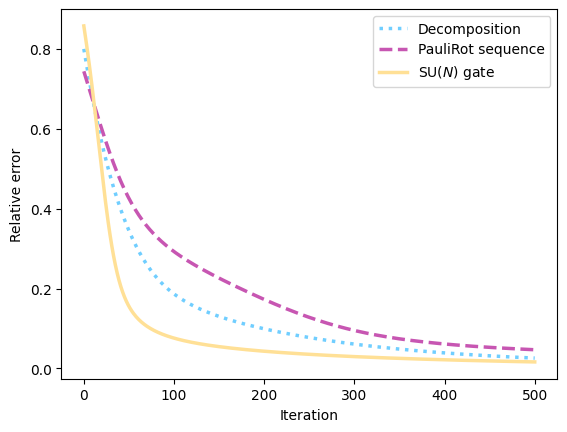

In [7]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
styles = [":", "--", "-"]
colors = ["#70CEFF", "#C756B2", "#FFE096"]
for (name, energy), c, ls in zip(energies.items(), colors, styles):
    error = (energy - E_min_noisy) / abs(E_min_noisy)
    ax.plot(list(range(len(error))), error, label=name, c=c, ls=ls, lw=2.5)

ax.set(xlabel="Iteration", ylabel="Relative error")
ax.legend()
plt.show()

In [9]:
# For Ising Model
# Added the Noisy Channel in Hamiltonian
from qiskit.quantum_info import SparsePauliOp

num_wires = 2
wires = list(range(num_wires))
np.random.seed(62213)

# Define the Hamiltonian
hamiltonian = SparsePauliOp.from_list([
    ("ZZ", 1), ("XI", 1), ("IX", 1),
])

# Convert the SparsePauliOp to a matrix
H_matrix = hamiltonian.to_matrix()
H = qml.Hermitian(H_matrix, wires=wires)

# Compute the eigenvalues and eigenvectors of the Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

# Add noise to the eigenvalues
noise = np.random.randn(eigenvalues.shape[0]) * 10  # Adjust noise scale as needed
noisy_eigenvalues = eigenvalues + noise

# Reconstruct the noisy Hamiltonian using the noisy eigenvalues and original eigenvectors
noisy_H_matrix = eigenvectors @ np.diag(noisy_eigenvalues) @ np.linalg.inv(eigenvectors)
noisy_H = qml.Hermitian(noisy_H_matrix, wires=wires)

# Compute the ground state energy of the noisy Hamiltonian
E_min_noisy = min(qml.eigvals(noisy_H))
print(f"Noisy ground state energy: {E_min_noisy:.5f}")

# Optional: Print the noisy eigenvalues
print("Noisy eigenvalues:", qml.eigvals(noisy_H))
noisy_H



Noisy ground state energy: -13.89402
Noisy eigenvalues: [-13.89401968  -3.28558849   0.57303664  11.34010553]


Hermitian(array([[-2.7649294 +0.j,  2.40758979+0.j,  2.40758979+0.j,
        11.12909028+0.j],
       [ 2.40758979+0.j,  0.1316964 +0.j,  3.41728489+0.j,
         2.40758979+0.j],
       [ 2.40758979+0.j,  3.41728489+0.j,  0.1316964 +0.j,
         2.40758979+0.j],
       [11.12909028+0.j,  2.40758979+0.j,  2.40758979+0.j,
        -2.7649294 +0.j]]), wires=[0, 1])

In [10]:
num_wires = 2  # Number of qubits
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))
dev = qml.device("default.qubit", wires=num_wires)

# Two blocks with two layers. Each layer contains two operations with d parameters
param_shape = (2, 2, 1, d)

init_params = np.random.randn(*param_shape)  # Random initialization

#init_params = np.zeros(param_shape)
init_params

# def circuit(params, operation=None):
#     """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
#     Parameters are assumed to have the dimensions (number of blocks, number of
#     wires per operation, number of operations per layer, and number of parameters
#     per operation), in that order.
#     """
#     for params_block in params:
#         for i, params_layer in enumerate(params_block):
#             for j, params_op in enumerate(params_layer):
#                 wires_op = [(loc * j + i + w) % num_wires for w in range(loc)]
                
#                 operation(params_op, wires_op)
#     return qml.expval(noisy_H)

# qnode = qml.QNode(circuit, dev, interface="jax")
# print(qml.draw(qnode)(init_params, qml.SpecialUnitary))




array([[[[ 0.01656627, -0.68452791, -1.6799127 ,  1.34690419,
          -1.04046067,  1.47349803, -1.21217715, -1.18701893,
           1.89987269,  0.3471159 , -0.07701672, -0.04574015,
           0.92973742,  0.00584895, -0.2269609 ]],

        [[-0.89847928, -0.31474624, -1.60953807, -0.59938898,
          -0.05150455, -0.02173493,  0.30009478,  0.10527259,
           1.04375464,  0.19805149,  1.23657944, -0.52494504,
          -0.52798952, -1.11309839,  1.23147829]]],


       [[[-0.51800531,  1.14497391,  0.68116142, -0.33613745,
           0.12654926,  1.0804718 ,  0.9436035 ,  0.47985867,
          -0.75368576, -0.13360184,  2.36361475, -0.28311481,
          -1.5504816 ,  0.57904216,  0.61497654]],

        [[ 0.24492437, -0.2513241 , -0.08806063, -0.01112426,
           1.06437451,  0.34696924,  0.76943638, -0.20520814,
          -0.75148976, -0.50184713, -1.71335738,  0.38554155,
           0.55660615,  0.34816277, -0.1052552 ]]]])